[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mirkhalilrehman/PyTorch-Image-Classifier/blob/main/cifar_updated.ipynb)


In [12]:
import torch
import numpy as np
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

# torch: Main library for working with PyTorch.
# numpy: Library for working with arrays and numerical operations.
# torchvision: Provides tools for working with image datasets, including CIFAR-10.
# transforms: Used to define preprocessing transformations on images.
# SubsetRandomSampler: Helps with creating a validation split by randomly selecting data indices.
# nn: Defines neural network layers and operations.
# F: Provides functions like activation functions for layers.
# optim: Optimizers like SGD for training the model.
# matplotlib.pyplot: Used for plotting graphs


In [13]:
gpu=torch.cuda.is_available()
if gpu:
  print('Cuda is available! Training on GPU')
else:
  print('Cuda is not available! Training on CPU')


Cuda is available! Training on GPU


In [14]:
from os.path import splitext
num_workers=0
batch_size=20
n_valid=0.2

transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])

train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=transform)
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=transform)

# Split the training data into training and validation sets
n_train=len(train_data)
indices=list(range(n_train))
np.random.shuffle(indices)
split=int(np.floor(n_valid*n_train))
train_idx,valid_idx=indices[split:],indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)


train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
val_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

# Class names
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


In [15]:
print(len(train_loader),len(val_loader),len(test_loader))

2000 500 500


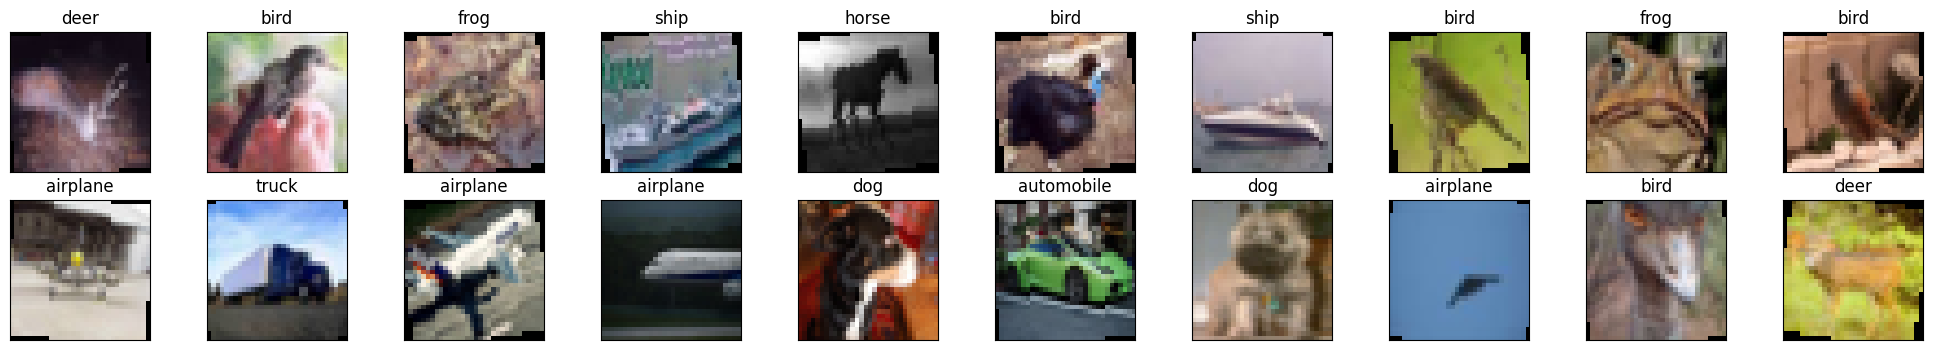

In [16]:
def imshow(img):
  img=img/2+0.5
  plt.imshow(np.transpose(img,(1,2,0)))

dataiter=iter(train_loader)
images,labels=next(dataiter)

images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])



In [7]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet,self).__init__()

    self.conv1=nn.Conv2d(3,16,3,padding=1)
    self.conv2=nn.Conv2d(16,16,3,padding=1)
    self.conv3=nn.Conv2d(16,64,3,padding=1)

    self.pool=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(64*4*4,500)
    self.fc2=nn.Linear(500,10)
    self.dropout=nn.Dropout(0.25)

  def forward(self,x):
    x=self.pool(F.elu(self.conv1(x)))
    x=self.pool(F.elu(self.conv2(x)))
    x=self.pool(F.elu(self.conv3(x)))

    x=x.view(-1,64*4*4) # Flatten the image
    x=self.dropout(x)
    x=F.elu(self.fc1(x))
    x=self.dropout(x)
    x=self.fc2(x)
    return x

In [8]:
# Convolutional Layers: Three Conv2d layers are used to extract features from the images. Each layer is followed by a ReLU activation (implemented using F.elu).
# Pooling: MaxPool2d is used after each convolutional layer to downsample the feature maps.
# Fully Connected Layers: After flattening the image tensor, two fully connected layers classify the image into one of 10 classes.
# Dropout: Applied to reduce overfitting.

In [17]:
model=ConvNet()
print(model)

if gpu:
  model.cuda()


ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [18]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)


In [19]:
n_epochs=40
valid_loss_min=np.Inf
train_losses,valid_losses=[],[]

for epoch in range(1,n_epochs+1):
  train_loss=0.0
  valid_loss=0.0

  model.train()
  for data,target in train_loader:
    if gpu:
      data,target=data.cuda(),target.cuda()

    optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,target)
    loss.backward()
    optimizer.step()
    train_loss +=loss.item()*data.size(0)

  model.eval()
  for data,target in val_loader:
    if gpu:
      data,target=data.cuda(),target.cuda()

    output=model(data)
    loss=criterion(output,target)
    valid_loss+=loss.item()*data.size(0)

  train_loss=train_loss/len(train_loader.dataset)
  valid_loss=valid_loss/len(val_loader.dataset)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f"Epoch:{epoch} \t Training Loss : {train_loss:.6f} \t Validation Loss: {valid_loss:.6f}")
  if valid_loss<=valid_loss_min:
    print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
    torch.save(model.state_dict(),'model_cifar.pt')
    valid_loss_min=valid_loss



Epoch:1 	 Training Loss : 1.527042 	 Validation Loss: 0.322262
Validation loss decreased (inf --> 0.322262). Saving model...
Epoch:2 	 Training Loss : 1.213301 	 Validation Loss: 0.280581
Validation loss decreased (0.322262 --> 0.280581). Saving model...
Epoch:3 	 Training Loss : 1.098074 	 Validation Loss: 0.259193
Validation loss decreased (0.280581 --> 0.259193). Saving model...
Epoch:4 	 Training Loss : 1.025343 	 Validation Loss: 0.244936
Validation loss decreased (0.259193 --> 0.244936). Saving model...
Epoch:5 	 Training Loss : 0.971283 	 Validation Loss: 0.233450
Validation loss decreased (0.244936 --> 0.233450). Saving model...
Epoch:6 	 Training Loss : 0.928329 	 Validation Loss: 0.222049
Validation loss decreased (0.233450 --> 0.222049). Saving model...
Epoch:7 	 Training Loss : 0.896263 	 Validation Loss: 0.213912
Validation loss decreased (0.222049 --> 0.213912). Saving model...
Epoch:8 	 Training Loss : 0.869542 	 Validation Loss: 0.203889
Validation loss decreased (0.213

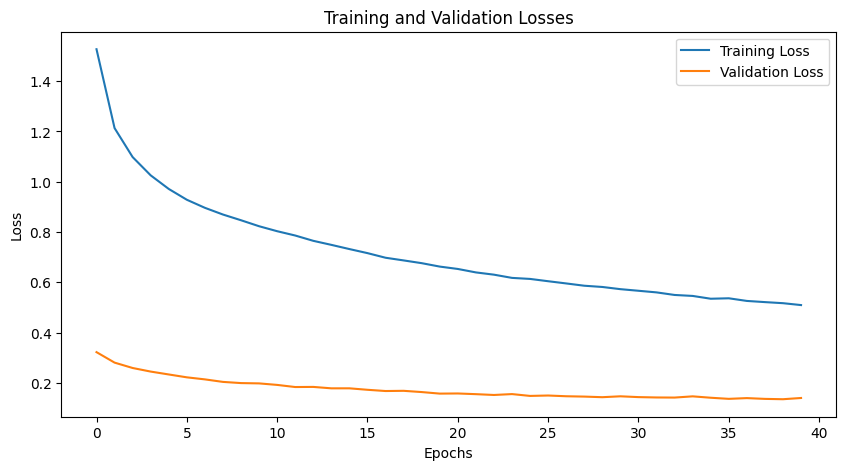

In [20]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<ipython-input-21-a6bc03727e9f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_cifar.pt'))


Test Loss: 0.667112


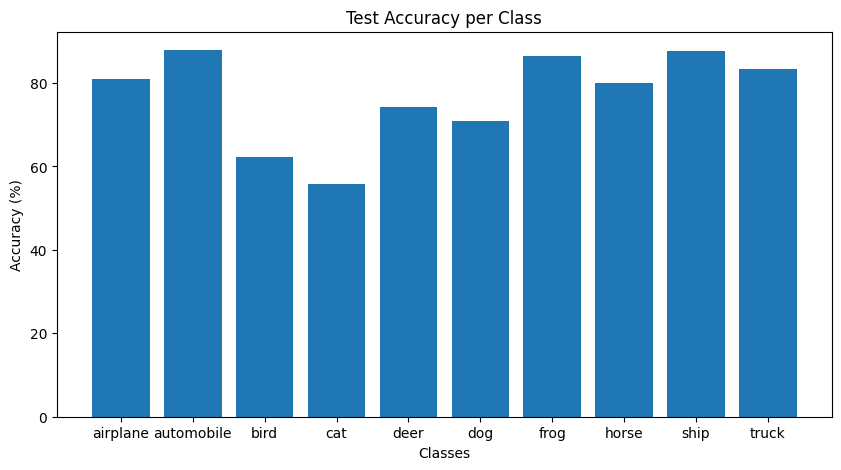


Test Accuracy (Overall): 76.91%


In [21]:
model.load_state_dict(torch.load('model_cifar.pt'))

test_loss = 0.0
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))

model.eval()
for data, target in test_loader:
    if gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}")

# Plot accuracies for each class
class_accuracies = [100 * class_correct[i] / class_total[i] for i in range(10)]

plt.figure(figsize=(10, 5))
plt.bar(classes, class_accuracies)
plt.title('Test Accuracy per Class')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.show()

# Overall test accuracy
print(f"\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total)}%")


In [22]:
for c, a in zip(classes, class_accuracies):
    print(c, "=", a)



airplane = 80.9
automobile = 87.9
bird = 62.2
cat = 55.7
deer = 74.3
dog = 70.8
frog = 86.4
horse = 79.9
ship = 87.7
truck = 83.3


In [30]:
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


model.load_state_dict(torch.load('model_cifar.pt'))
model.eval()


def predict_image(image_path):

    image = Image.open(image_path)
    image = image.convert('RGB')
    plt.imshow(image)
    image = transform(image).unsqueeze(0)
    if gpu:
        image = image.cuda()

    with torch.no_grad():
        output = model(image)

    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()




<ipython-input-30-f99de57c523b>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_cifar.pt'))


Predicted Class: frog


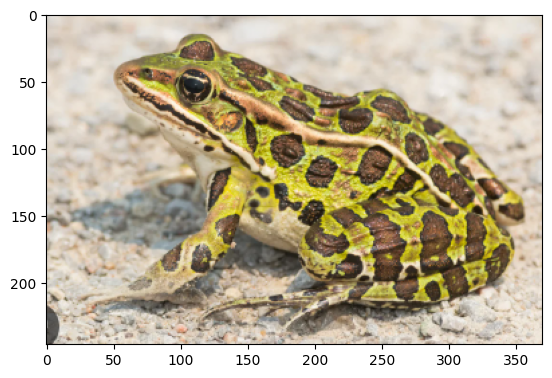

In [35]:

image_path = '//content//Screenshot 2025-01-14 172639.png'
predicted_class_index = predict_image(image_path)
print(f'Predicted Class: {classes[predicted_class_index]}')
